<a href="https://colab.research.google.com/github/jaesik103/NLP/blob/main/03.kor_en_translate_no_SentencePiece.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proj. 한-영 번역기 만들기

한-영 번역기 만들기
1. 데이터 다운로드
- 데이터 : https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1
- korean-english-park.train.tar.gz
2. 데이터 정제
- set 데이터형이 중복이 허용하지 않다는 것을 활용해 중복된 데이터를 제거
  - 데이터 병렬 쌍이 흐트러지지 않게 주의! <- **데이터프레임 변환 후 정제**
  - cleaned_corpus에 따로저장 <- **데이터프레임으로**
- 앞서 정의한 preprocessing()함수는 한글에 대해 동작하지 않아요.
  - 한글에 적용할 수 있는 정규식을 추가해여 함수를 재정의 하세요. <- **컬럼별로 map()를 사용해서 각각 preprocessing()**
- 타겟 언어인 영문엔 <\start>토큰과 <\end>토큰을 추가하고 split()함수로 토큰화 합니다. 한글 토큰화는 konlpy의 mecab클래스를 사용합니다. 
- cleaned_corpus로부터 토큰의길이가 40이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하기

3. 토큰화
- tokenize()함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요!
  - 단어수는 실험을 통해 적당한 값을 맞춰줍시다(최소 10000이상!) <- 

4. 훈련하기

5. **Subword Segmentation을 안하고, 영문에 split()으로 tokenize 한 결과와 비교**

# 0.모듈 설치 및 임포트

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
!nvidia-smi

Mon Apr  4 22:38:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from collections import Counter
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib

import time
import re
import os
import io
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab_light_220111.sh

# 1.데이터 준비

## 1.1 데이터 다운로드

In [ ]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
!tar -xzvf korean-english-park.train.tar.gz

In [ ]:
ko_path_to_file = './korean-english-park.train.ko'
# local인 경우, os.getenv('home')

with open(ko_path_to_file, "r") as f:
    ko_raw = f.read().splitlines()

print("Data Size :", len(ko_raw))

Data Size : 94123


In [ ]:
print("Examples :")
for sen in ko_raw[0:10]: print(">>", sen)

Examples :
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
>> 그러나 이것은 또한 책상도 필요로 하지 않는다.
>> 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
>> 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
>> 이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에, 전문가들은 테러 조직이 여전히 세계 경제에 타격을 입히려 한다고 경고하고 있으며, 동남 아시아에 있는 세계 경제의 주요 통로가 위험에 처해 있다고 그들은 생각하고 있다.
>> 국립 과학 학회가 발표한 새 보고서에따르면, 복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다.
>> 이 보고서에따르면, "특히, 군사 작전에서 생사가 걸린 상황이 될 수도 있는 반응 속도와 시각 및 청각의 경계 상태를 유지시키기 위해 카페인이 사용될 수도 있다." 고 한다.
>> "결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다."
>> 연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 연구하고 있다고 Archibald는 말했다.


In [ ]:
en_path_to_file = './korean-english-park.train.en'
# local인 경우, os.getenv('home')

with open(en_path_to_file, "r") as f:
    en_raw = f.read().splitlines()

print("Data Size :", len(en_raw))

Data Size : 94123


In [ ]:
print("Examples :")
for sen in en_raw[0:10]: print(">>", sen)

Examples :
>> Much of personal computing is about "can you top this?"
>> so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.
>> Like all optical mice, But it also doesn't need a desk.
>> uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.
>> Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.
>> After learning of several foiled al Qaeda attempts on U.S. and commercial ships in the area, experts are warning that the terror network still wants to cripple the global economy, the world's economic jugular vein in Southeast Asia is at risk.
>> Caffeine can help increase reaction time and improve performance for military servicemen who must perform complex tasks or who need help staying alert for 

## 1.1.1 데이터 중복, na 제거

In [ ]:
ko_list = []
en_list = []
for i in ko_raw:
    ko_list.append(i)
for i in en_raw:
    en_list.append(i)
ko_df = pd.DataFrame(ko_list, columns=['ko'])
en_df = pd.DataFrame(en_list, columns=['en'])
df = pd.concat([ko_df,en_df], axis = 1)
df

,ko,en
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
94118,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...
94119,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.


In [ ]:
print('dic 갯수 :', len(df))

# 중복 제거
df.drop_duplicates(subset=['ko'], inplace=True)
df.drop_duplicates(subset=['en'], inplace=True)

# Nan 결측치 제거
cleaned_df = df.dropna(how='any')
print('정제 후 df 갯수 :', len(cleaned_df))

dic 갯수 : 94123
정제 후 df 갯수 : 74849


## 1.1.2 preprocessing 함수 정의

In [ ]:
def en_preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence
    
    if e_token:
        sentence += ' <end>'

    return sentence

In [ ]:
def kor_preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence
    
    if e_token:
        sentence += ' <end>'

    return sentence

### 1.1.2.1 preprocessing & 토큰 수 40 이하 데이터 삭제
- 토큰 수가 많은 ko 기준으로

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

In [ ]:
df['ko'] = df['ko'].map(lambda x : kor_preprocess_sentence(x))
df['en'] = df['en'].map(lambda x : en_preprocess_sentence(x, s_token=True, e_token=True)) 

In [ ]:
df

,ko,en
0,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?,<start> much of personal computing is about ca...
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,<start> so a mention a few weeks ago about a r...
2,그러나 이것은 또한 책상도 필요로 하지 않는다 .,"<start> like all optical mice , but it also do..."
3,". 달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 , 팔 , 그외에 어떤 부분이...",<start> uses gyroscopic sensors to control the...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 테러 계획들이 실패로 돌아갔음을...,<start> intelligence officials have revealed a...
...,...,...
94118,우리는 월 일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 총력을...,<start> we are hoping to seize material eviden...
94119,월요일 술집 종업원 명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다 .,"<start> on monday , police secured statements ..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다 .,<start> but the lack of material evidence is m...
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다 .,<start> kim and his son both deny the allegati...


In [ ]:
df_1 = df.copy()
df_1['ko'] = df_1['ko'].map(lambda x : mecab.morphs(x))

In [ ]:
df_1

,ko,en
0,"[개인, 용, 컴퓨터, 사용, 의, 상당, 부분, 은, 이것, 보다, 뛰어날, 수,...",<start> much of personal computing is about ca...
1,"[모든, 광, 마우스, 와, 마찬가지, 로, 이, 광, 마우스, 도, 책상, 위, ...",<start> so a mention a few weeks ago about a r...
2,"[그러나, 이것, 은, 또한, 책상, 도, 필요, 로, 하, 지, 않, 는다, .]","<start> like all optical mice , but it also do..."
3,"[., 달러, 하, 는, 이, 최첨단, 무선, 광, 마우스, 는, 허공, 에서, 팔...",<start> uses gyroscopic sensors to control the...
4,"[정보, 관리, 들, 은, 동남, 아시아, 에서, 의, 선박, 들, 에, 대한, 많...",<start> intelligence officials have revealed a...
...,...,...
94118,"[우리, 는, 월, 일, 김승연, 회장, 과, 그, 의, 아들, 이, 보복, 폭행,...",<start> we are hoping to seize material eviden...
94119,"[월요일, 술집, 종업원, 명, 은, 김, 회장, 과, 아들, 에게, 폭행, 을, ...","<start> on monday , police secured statements ..."
94120,"[그러나, 불, 충분, 한, 증거, 확보, 로, 수사, 에, 어려움, 이, 있, 다...",<start> but the lack of material evidence is m...
94121,"[김, 회장, 과, 그, 의, 아들, 은, 보복, 폭행, 혐의, 를, 강력히, 부인...",<start> kim and his son both deny the allegati...


In [ ]:
df_2 = df_1.copy()
df_2['ko'] = df_2['ko'].map(lambda x : len(x))
del_index = df_2[df_2['ko']>38].index

In [ ]:
df = df.drop(del_index, axis = 0)
df

,ko,en
0,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?,<start> much of personal computing is about ca...
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,<start> so a mention a few weeks ago about a r...
2,그러나 이것은 또한 책상도 필요로 하지 않는다 .,"<start> like all optical mice , but it also do..."
8,결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다 .,<start> something that will boost their capabi...
9,연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 ...,<start> researchers are already exploring ways...
...,...,...
94118,우리는 월 일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 총력을...,<start> we are hoping to seize material eviden...
94119,월요일 술집 종업원 명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다 .,"<start> on monday , police secured statements ..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다 .,<start> but the lack of material evidence is m...
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다 .,<start> kim and his son both deny the allegati...


## 1.1.3 한글 tokenizer

In [ ]:
# 한글 학습용 코퍼스 txt파일 생성
with open('ko_train.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(map(str,df['ko'])))

In [ ]:
def tokenize(corpus): 
    tokenizer = Tokenizer(filters='') 
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus) # 텍스트 -> 시퀀스
    tensor = pad_sequences(tensor, padding='post', maxlen = 40)

    return tensor, tokenizer

In [ ]:
def mecab_split(sentence):
    a = mecab.morphs(sentence)
    a.insert(0, '<start> ')
    a.append(' <end>')
    return a

mecab_corpus = []
ko_data_txt = open('ko_train.txt', 'r')
for kor in ko_data_txt:
    mecab_corpus.append(mecab_split(kor)) # 텍스트
ko_data_txt.close()

In [ ]:
ko_tensor, ko_tokenizer = tokenize(mecab_corpus)
print("korean Vocab Size :", len(ko_tokenizer.index_word))

korean Vocab Size : 36952


In [ ]:
ko_tensor[5]

array([   2, 7991, 1244,    6,   64,   10, 1093,  120,   10, 1488, 3050,
         13,   38,   66,  272,   15, 1285, 1929,   12,  136,   58, 1130,
        804,  189,   27,  879, 1093, 6156,    8, 4385,  189,    5,    4,
          1,    3,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
ko_tokenizer.index_word[2]

'<start> '

## 1.1.4 영문 tokenizer

In [ ]:
# en 코퍼스 파일 생성
with open('en_train.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(map(str,df['en'])))

In [ ]:
en_train_txt = open('en_train.txt', 'r')
enc_corpus = []
for en in en_train_txt:
    enc_corpus.append(en)
en_tensor, en_tokenizer = tokenize(enc_corpus)

In [ ]:
print("English Vocab Size :", len(en_tokenizer.index_word))

English Vocab Size : 39049


In [ ]:
print(ko_tensor)
len(ko_tensor[1000])

[[   2  701  618 ...    0    0    0]
 [   2  217 5233 ...    0    0    0]
 [   2   79  663 ...    0    0    0]
 ...
 [   2   79  355 ...    0    0    0]
 [   2  880  636 ...    0    0    0]
 [   2   71    9 ...    0    0    0]]


40

In [ ]:
print(en_tensor)
len(en_tensor[1000])

[[  4 272   7 ...   0   0   0]
 [  4 143   8 ...   0   0   0]
 [  4 163  78 ...   0   0   0]
 ...
 [  4  32   1 ...   0   0   0]
 [  4 297  10 ...   0   0   0]
 [  4  63  31 ...   0   0   0]]


40

In [ ]:
print(len(ko_tensor))
print(len(en_tensor))

60279
60279


## 1.1.5 훈련, 검증 데이터 분리

In [ ]:
# 훈련 데이터와 검증 데이터로 분리하기 (80/20) ---> test_size = 0.2
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(ko_tensor, en_tensor, test_size=0.2)

print("Korean Vocab Size : ", len(ko_tokenizer.index_word))
print("English Vocab Size : ", len(en_tokenizer.index_word))

Korean Vocab Size :  36952
English Vocab Size :  39049


In [ ]:
input_tensor_train[5]

array([    2,   576,  1779,    18,     9,   576,   462, 28643,    15,
        1125,  9241,    27,     5,   106,   476,     9,   517,   845,
          26, 13965,  1029,     7,    13,     6,  1256,  5605,  1029,
         320,     7,   604,    19,   476,     5,    36,    32,    11,
           4,     1,     3,     0], dtype=int32)

In [ ]:
ko_tokenizer.sequences_to_texts([input_tensor_train[5]])

['<start>  이탈리아 수사관 들 은 이탈리아 북부 롬바르디아 가 본 거지 인 이 테러 조직 은 군사 훈련 과 이념 교육 을 하 는 장기 지하드 교육 프로그램 을 운영 한 조직 이 라고 말 했 다 .  <end>']

In [ ]:
target_tensor_train[5]

array([    4,     1,   444,   939,  1010,    17,   322,     9,     1,
         414,  1125,   399,     7, 30005,    10,   672,   126,  1094,
         145,     8,   206,   609, 14502,   304,    52,  1533,    96,
          10, 13230,  1376,     2,     5,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

In [ ]:
en_tokenizer.index_word[5]

'<end>\n'

In [ ]:
target_tensor_train[5]

array([    4,     1,   444,   939,  1010,    17,   322,     9,     1,
         414,  1125,   399,     7, 30005,    10,   672,   126,  1094,
         145,     8,   206,   609, 14502,   304,    52,  1533,    96,
          10, 13230,  1376,     2,     5,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

In [ ]:
en_tokenizer.sequences_to_texts([target_tensor_train[5]])

['<start> the main terrorist cell was based in the northern italian region of lombardy and involved what investigators called a long term jihadist program which provided military and ideological training . <end>\n']

# 2.모델 설계

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(ko_tokenizer.word_index)+1
vocab_tar_size = len(en_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 40]), TensorShape([64, 40]))

![](https://aiffelstaticprd.blob.core.windows.net/media/images/GN-4-P-2.max-800x600.jpg)

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 샘플 입력
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 40, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # 쿼리 은닉 상태(query hidden state)는 (batch_size, hidden size)쌍으로 이루어져 있습니다.
    # query_with_time_axis은 (batch_size, 1, hidden size)쌍으로 이루어져 있습니다.
    # values는 (batch_size, max_len, hidden size)쌍으로 이루어져 있습니다.
    # 스코어(score)계산을 위해 덧셈을 수행하고자 시간 축을 확장하여 아래의 과정을 수행합니다.
    query_with_time_axis = tf.expand_dims(query, 1)

    # score는 (batch_size, max_length, 1)쌍으로 이루어져 있습니다.
    # score를 self.V에 적용하기 때문에 마지막 축에 1을 얻습니다.
    # self.V에 적용하기 전에 텐서는 (batch_size, max_length, units)쌍으로 이루어져 있습니다.
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights는 (batch_size, max_length, 1)쌍으로 이루어져 있습니다. 
    attention_weights = tf.nn.softmax(score, axis=1)

    # 덧셈이후 컨텍스트 벡터(context_vector)는 (batch_size, hidden_size)쌍으로 이루어져 있습니다.
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 40, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # 어텐션을 사용합니다.
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output는 (batch_size, max_length, hidden_size)쌍으로 이루어져 있습니다.
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # 임베딩층을 통과한 후 x는 (batch_size, 1, embedding_dim)쌍으로 이루어져 있습니다.
    x = self.embedding(x)

    # 컨텍스트 벡터와 임베딩 결과를 결합한 이후 x의 형태는 (batch_size, 1, embedding_dim + hidden_size)쌍으로 이루어져 있습니다.
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 위에서 결합된 벡터를 GRU에 전달합니다.
    output, state = self.gru(x)

    # output은 (batch_size * 1, hidden_size)쌍으로 이루어져 있습니다.
    output = tf.reshape(output, (-1, output.shape[2]))

    # output은 (batch_size, vocab)쌍으로 이루어져 있습니다.
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 39050)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([en_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # 교사 강요(teacher forcing) - 다음 입력으로 타겟을 피딩(feeding)합니다.
    for t in range(1, targ.shape[1]):
      # enc_output를 디코더에 전달합니다.
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # 교사 강요(teacher forcing)를 사용합니다.
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # 에포크가 2번 실행될때마다 모델 저장 (체크포인트)
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 6.2114
Epoch 1 Batch 100 Loss 3.8011
Epoch 1 Batch 200 Loss 3.3629
Epoch 1 Batch 300 Loss 3.6000
Epoch 1 Batch 400 Loss 3.3202
Epoch 1 Batch 500 Loss 3.6192
Epoch 1 Batch 600 Loss 3.2296
Epoch 1 Batch 700 Loss 3.4878
Epoch 1 Loss 3.7521
Time taken for 1 epoch 342.1815962791443 sec

Epoch 2 Batch 0 Loss 2.9684
Epoch 2 Batch 100 Loss 3.1822
Epoch 2 Batch 200 Loss 3.5107
Epoch 2 Batch 300 Loss 3.3553
Epoch 2 Batch 400 Loss 3.1868
Epoch 2 Batch 500 Loss 3.5085
Epoch 2 Batch 600 Loss 3.1045
Epoch 2 Batch 700 Loss 3.1326
Epoch 2 Loss 3.2653
Time taken for 1 epoch 296.90341544151306 sec

Epoch 3 Batch 0 Loss 3.1089
Epoch 3 Batch 100 Loss 3.1480
Epoch 3 Batch 200 Loss 3.2056
Epoch 3 Batch 300 Loss 3.0188
Epoch 3 Batch 400 Loss 2.7586
Epoch 3 Batch 500 Loss 2.8923
Epoch 3 Batch 600 Loss 2.9233
Epoch 3 Batch 700 Loss 3.2022
Epoch 3 Loss 2.9579
Time taken for 1 epoch 293.37618017196655 sec

Epoch 4 Batch 0 Loss 2.7579
Epoch 4 Batch 100 Loss 2.7775
Epoch 4 Batch 200 Loss 2.711

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((40, 40))

  sentence = kor_preprocess_sentence(sentence)
  inputs = mecab.morphs(sentence)
  inputs.insert(0, '<start> ')
  inputs.append(' <end>')
  inputs = [ko_tokenizer.word_index[i] for i in inputs]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=40,
                                                         padding='post')
  #inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([en_tokenizer.word_index['<start>']], 0)

  for t in range(40):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # 나중에 어텐션 가중치를 시각화하기 위해 어텐션 가중치를 저장합니다.
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += en_tokenizer.index_word[predicted_id] + ' '

    if en_tokenizer.index_word[predicted_id] == '<end>\n':
      return result, sentence, attention_plot

    # 예측된 ID를 모델에 다시 피드합니다.
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# 어텐션 가중치를 그리기 위한 함수입니다.
plt.rc('font', family='NanumBarunGothic')

def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')



  fontdict = {'fontsize': 14}

  sentence = kor_preprocess_sentence(sentence)
  sentence = mecab.morphs(sentence)
  sentence.insert(0, '<start> ')
  sentence.append(' <end>')

  ax.set_xticklabels([''] + sentence, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(mecab.morphs(sentence))+2]
  plot_attention(attention_plot, sentence, result.split(' '))

Input: 도대체 어째서 이런 일이 발생한 것일까
Predicted translation: the trial may have been repeated . <end>
 


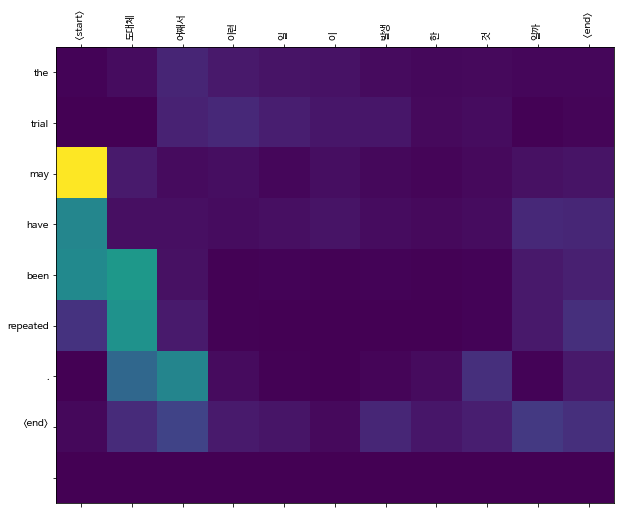

In [ ]:
translate('도대체 어째서 이런 일이 발생한 것일까')

Input: 북한은 핵실험을 강행할 것으로 예측된다 .
Predicted translation: north korea is prepared to resume international pressure . <end>
 


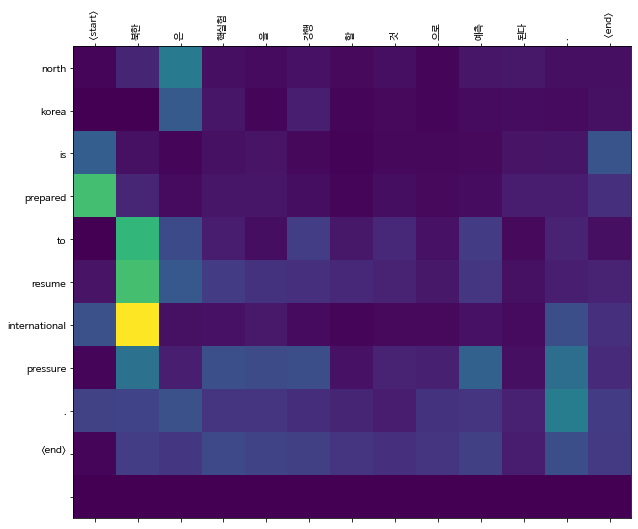

In [ ]:
translate('북한은 핵실험을 강행할 것으로 예측된다.')

Input: 현대자동차가 전기차를 개발 중이다
Predicted translation: the company has a new era in the company <end>
 


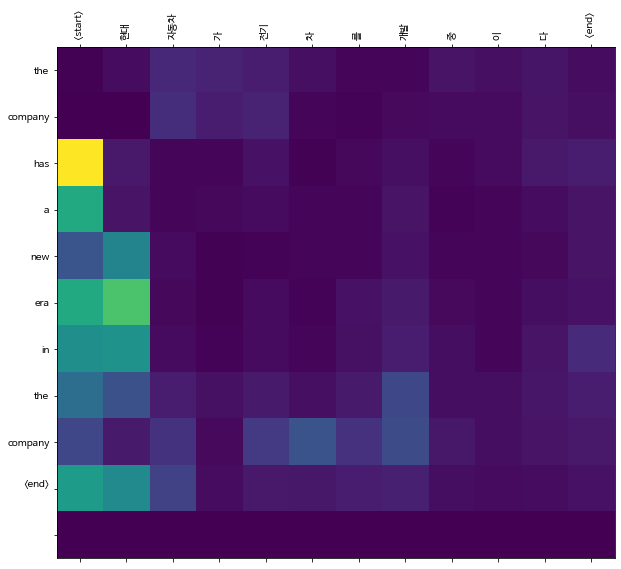

In [ ]:
translate('현대자동차가 전기차를 개발 중이다')

Input: 내일은 집중호우가 내릴 예정이다
Predicted translation: the new entity is expected to be prepared to be prepared to be prepared to be prepared to be prepared to be prepared to be prepared to be prepared to be prepared to be prepared to be prepared to be 


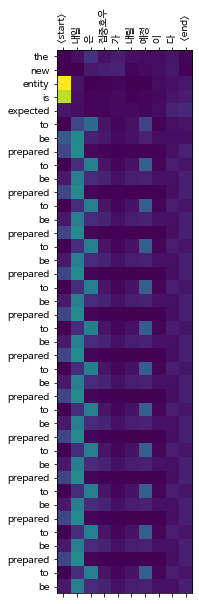

In [ ]:
translate('내일은 집중호우가 내릴 예정이다')

Input: 이게 무슨 일인가 ?
Predicted translation: what s a good thing ? <end>
 


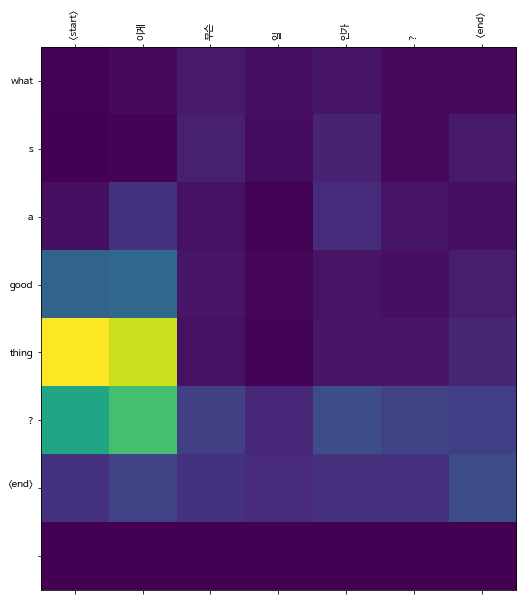

In [ ]:
translate('이게 무슨 일인가?')

Input: 올림픽이 곧 개최된다
Predicted translation: the shanghai campaign has been chosen for the olympics . <end>
 


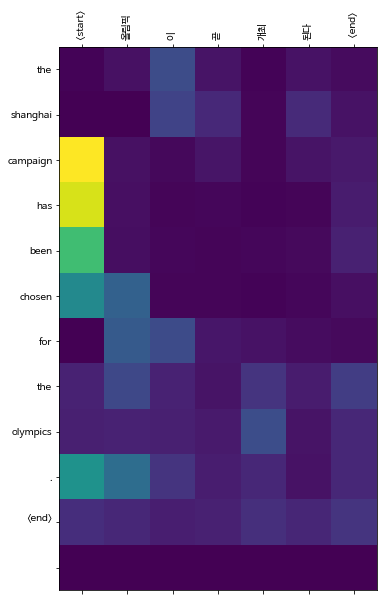

In [ ]:
translate('올림픽이 곧 개최된다')

Input: 미국 대통령 선거가 끝났다
Predicted translation: the presidential election draws the two leaders of the two leaders of the two leaders of the election campaign has been voting . <end>
 


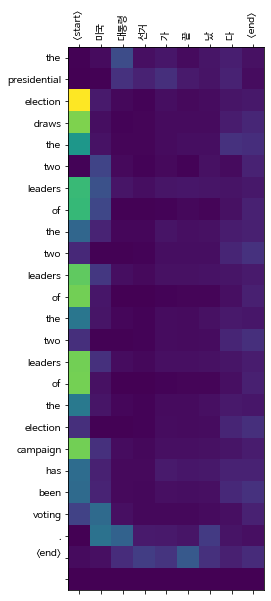

In [ ]:
translate('미국 대통령 선거가 끝났다')

# 3.과적합 확인

In [ ]:
@tf.function
def test_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([en_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # 교사 강요(teacher forcing) - 다음 입력으로 타겟을 피딩(feeding)합니다.
    for t in range(1, targ.shape[1]):
      # enc_output를 디코더에 전달합니다.
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # 교사 강요(teacher forcing)를 사용합니다.
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(test_dataset.take(steps_per_epoch)):
    batch_loss = test_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # 에포크가 2번 실행될때마다 모델 저장 (체크포인트)
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 6.3725
Epoch 1 Batch 100 Loss 3.8239
Epoch 1 Loss 1.0192
Time taken for 1 epoch 146.09712147712708 sec

Epoch 2 Batch 0 Loss 3.9018
Epoch 2 Batch 100 Loss 3.8290
Epoch 2 Loss 0.9194
Time taken for 1 epoch 77.17036414146423 sec

Epoch 3 Batch 0 Loss 3.4626
Epoch 3 Batch 100 Loss 3.8276
Epoch 3 Loss 0.8785
Time taken for 1 epoch 73.59541893005371 sec

Epoch 4 Batch 0 Loss 3.2496
Epoch 4 Batch 100 Loss 3.5098
Epoch 4 Loss 0.8418
Time taken for 1 epoch 76.6546893119812 sec

Epoch 5 Batch 0 Loss 3.2518
Epoch 5 Batch 100 Loss 3.4032
Epoch 5 Loss 0.8055
Time taken for 1 epoch 73.54921269416809 sec

Epoch 6 Batch 0 Loss 3.0041
Epoch 6 Batch 100 Loss 3.1627
Epoch 6 Loss 0.7728
Time taken for 1 epoch 76.60919880867004 sec

Epoch 7 Batch 0 Loss 3.0003
Epoch 7 Batch 100 Loss 2.8653
Epoch 7 Loss 0.7432
Time taken for 1 epoch 73.54404044151306 sec

Epoch 8 Batch 0 Loss 2.7265
Epoch 8 Batch 100 Loss 2.8450
Epoch 8 Loss 0.7162
Time taken for 1 epoch 76.66972851753235 sec

Epoch 9 